In [1]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

In [2]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [22]:
watched_hour = run_query('''
SELECT request_date, title_name, title_id, season_number, SUM(hours_viewed) as total_hours_viewed
FROM max_dev.workspace.user_title_hours_watched_test2 a
JOIN max_dev.workspace.user_title_hours_watched_episodic_info b
ON  a.viewable_id = b.viewable_id
GROUP BY 1,2,3,4
ORDER BY total_hours_viewed desc
''')

In [37]:
# watched_hour['date_month'] = pd.to_datetime(watched_hour['request_date']).dt.to_period('M')
watched_hour['date_month'] = pd.to_datetime(watched_hour['date_month'])#.dt.to_timestamp()

In [38]:
watched_hour.head()

,request_date,title_name,title_id,season_number,total_hours_viewed,date_month
0,2022-01-02,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,5.263764e+07,2022-01-01
1,2021-08-07,The Suicide Squad,GYOxtow3Wz8PDwgEAAAdw,0,4.271683e+07,2021-08-01
2,2021-12-24,The Matrix Resurrections,GYbD1_wnm3mDCwgEAAAPM,0,3.709334e+07,2021-12-01
3,2022-04-18,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,3.320418e+07,2022-04-01
4,2021-09-05,San Andreas,GYK0DcgxUPqrCwgEAAAAn,0,2.939340e+07,2021-09-01


In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

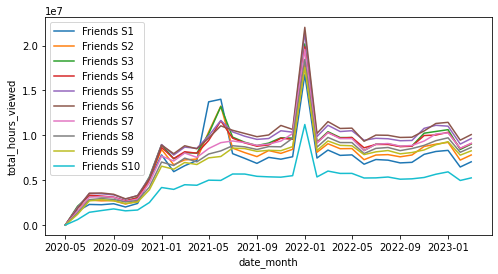

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(1, 11, 1):
    plot_df = watched_hour[(watched_hour['title_name'] == 'Friends') &(watched_hour['season_number'] == i)]
    plot_df = plot_df.groupby(['date_month', 'title_name', 'title_id'])['total_hours_viewed'].sum().reset_index()
    plt.plot(plot_df['date_month'], plot_df['total_hours_viewed'], label= 'Friends S' + str(i))

ax.set_xlabel('date_month')
ax.set_ylabel('total_hours_viewed')
ax.legend()

plt.show()

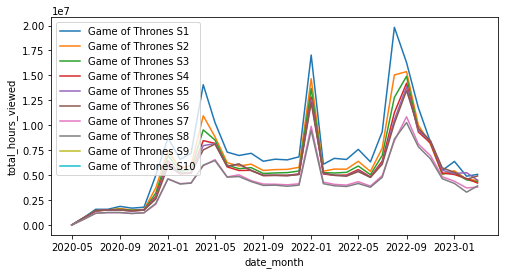

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(1, 11, 1):
    plot_df = watched_hour[(watched_hour['title_name'] == 'Game of Thrones') &(watched_hour['season_number'] == i)]
    plot_df = plot_df.groupby(['date_month', 'title_name', 'title_id'])['total_hours_viewed'].sum().reset_index()
    plt.plot(plot_df['date_month'], plot_df['total_hours_viewed'], label= 'Game of Thrones S' + str(i))

ax.set_xlabel('date_month')
ax.set_ylabel('total_hours_viewed')
ax.legend()

plt.show()

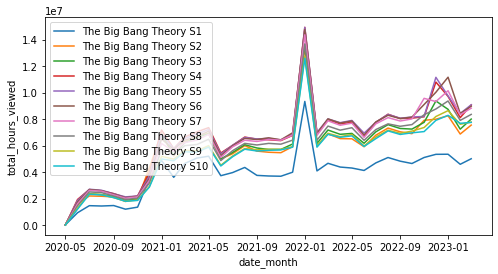

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(1, 11, 1):
    plot_df = watched_hour[(watched_hour['title_name'] == 'The Big Bang Theory') &(watched_hour['season_number'] == i)]
    plot_df = plot_df.groupby(['date_month', 'title_name', 'title_id'])['total_hours_viewed'].sum().reset_index()
    plt.plot(plot_df['date_month'], plot_df['total_hours_viewed'], label= 'The Big Bang Theory S' + str(i))

ax.set_xlabel('date_month')
ax.set_ylabel('total_hours_viewed')
ax.legend()

plt.show()

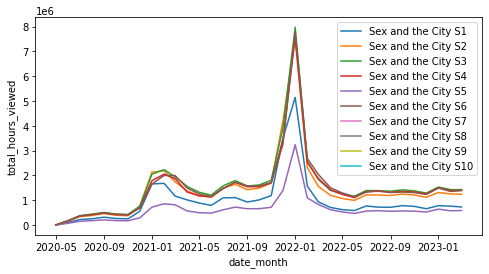

In [45]:
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(1, 11, 1):
    plot_df = watched_hour[(watched_hour['title_name'] == 'Sex and the City') &(watched_hour['season_number'] == i)]
    plot_df = plot_df.groupby(['date_month', 'title_name', 'title_id'])['total_hours_viewed'].sum().reset_index()
    plt.plot(plot_df['date_month'], plot_df['total_hours_viewed'], label= 'Sex and the City S' + str(i))

ax.set_xlabel('date_month')
ax.set_ylabel('total_hours_viewed')
ax.legend()

plt.show()